# Adaptive RK4 Orbits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll use an implementation of the orbit problem with RK4 written as a module.  The source (in both C++ and python) is here:

https://github.com/zingale/computational_astrophysics/tree/main/examples/ODEs

In [2]:
import orbit_adaptive as orbit

Let's first look at the source

In [3]:
%cat orbit_adaptive.py

"""
orbital motion.  We consider low mass objects orbiting the Sun.  We
work in units of AU, yr, and solar masses.  From Kepler's third law:

4 pi**2 a**3 = G M P**2

if a is in AU, P is in yr, and M is in solar masses, then

a**3 = P**2

and therefore

4 pi**2 = G

we work in coordinates with the Sun at the origin

This version implements adaptive timestepping
"""

import numpy as np
import matplotlib.pyplot as plt

# global parameters
GM = 4.0 * np.pi**2  # assuming M = 1 solar mass

class OrbitState:
    # a container to hold the star positions
    def __init__(self, x, y, u, v):
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return OrbitState(self.x + other.x, self.y + other.y,
                          self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return OrbitState(self.x - other.x, self.y - other.y,
                          self.u - other.u, self.v - other.v)

    def __mul__(self, o

## Highly eccentric orbit

Let's create an orbit with a tolerance of $10^{-5}$, and the a very high eccentricity ($a = 1$, $e = 0.95$)

In [4]:
o = orbit.OrbitsRK4(1.0, 0.95)
o.integrate(0.05, 1.e-5, o.kepler_period())

How many points did it take?

In [5]:
o.npts()

92

Let's plot it

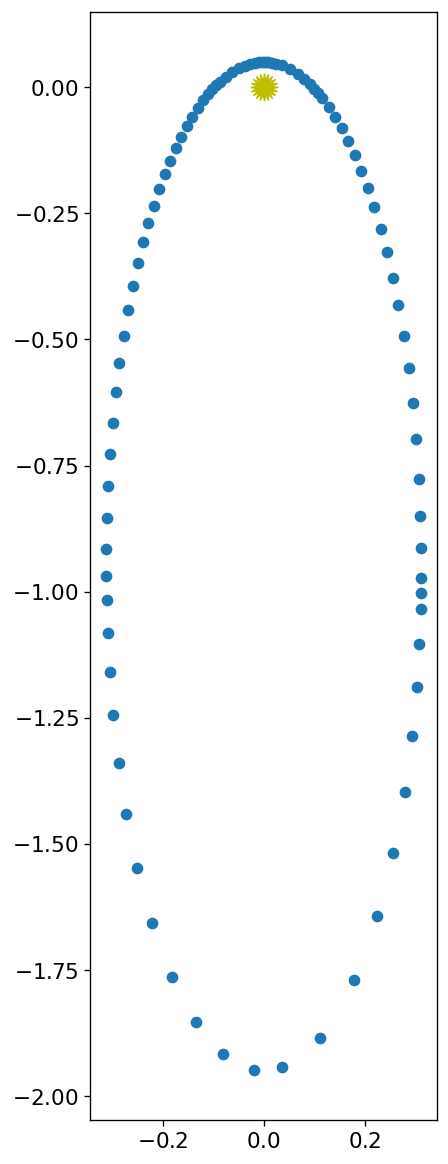

In [6]:
fig = o.plot(points=True)
fig.set_size_inches(5, 12)

Clearly we see that the size of the timestep is much larger at aphelion as compared to perihelion.

Let's create a version with a fixed timestep, with a timestep of $0.001~\mathrm{yr}$.  We can do this by passing in a negative error.

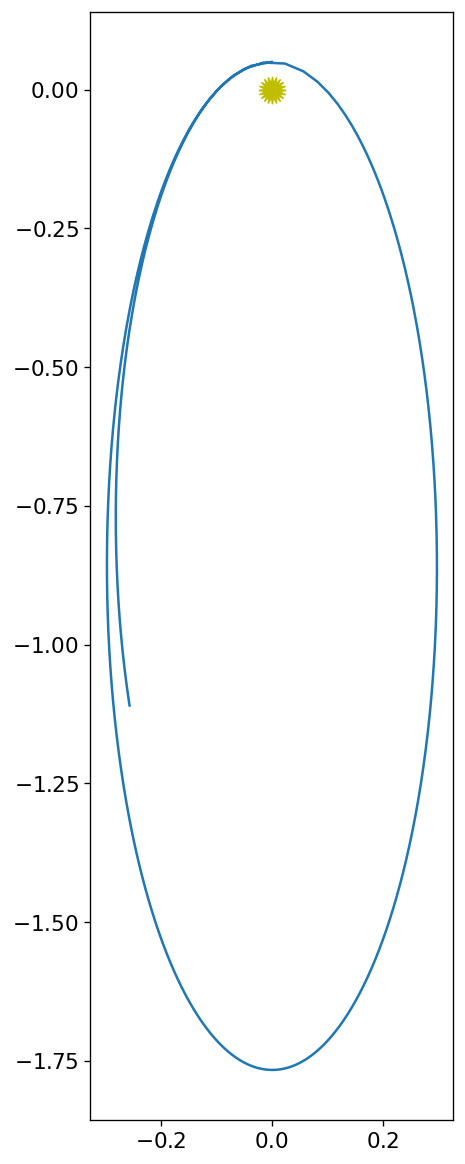

In [7]:
o_fixed = orbit.OrbitsRK4(1.0, 0.95)
o_fixed.integrate(0.001, -1, o_fixed.kepler_period())
fig = o_fixed.plot()
fig.set_size_inches(5, 12)

In [8]:
print(o_fixed.npts())

1001


We need a really small fixed step size to integrate this at all reasonably

Let's look at the adaptive version some more.  First, let's look at the timestep evolution.

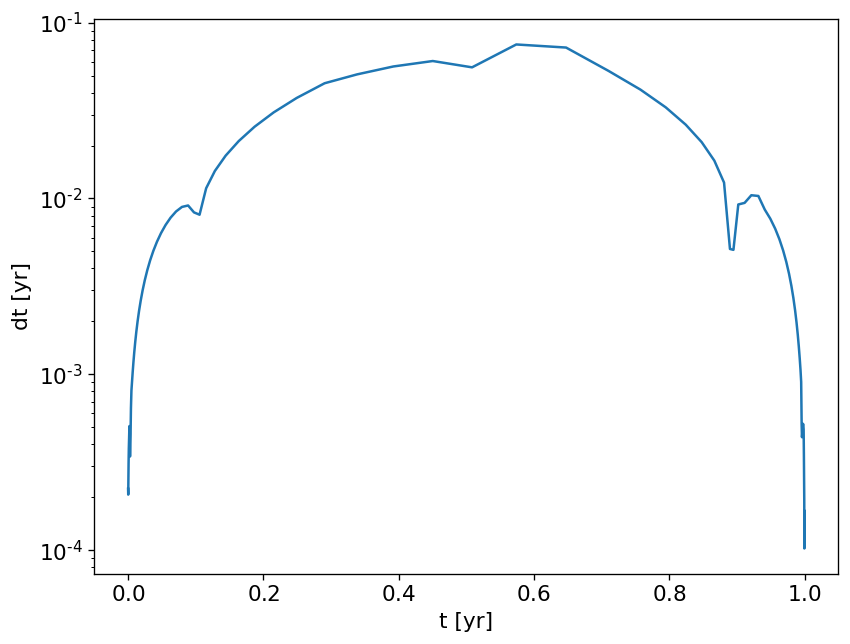

In [9]:
ts = np.array(o.time)

dt = ts[1:] - ts[:-1]
tc = 0.5 * (ts[1:] + ts[:-1])

fig, ax = plt.subplots()
ax.plot(tc, dt)
ax.set_xlabel("t [yr]")
ax.set_ylabel("dt [yr]")
ax.set_yscale("log")

Notice that the timestep changes by ~ 3 orders of magnitude over the evolution.

What about energy conservation?

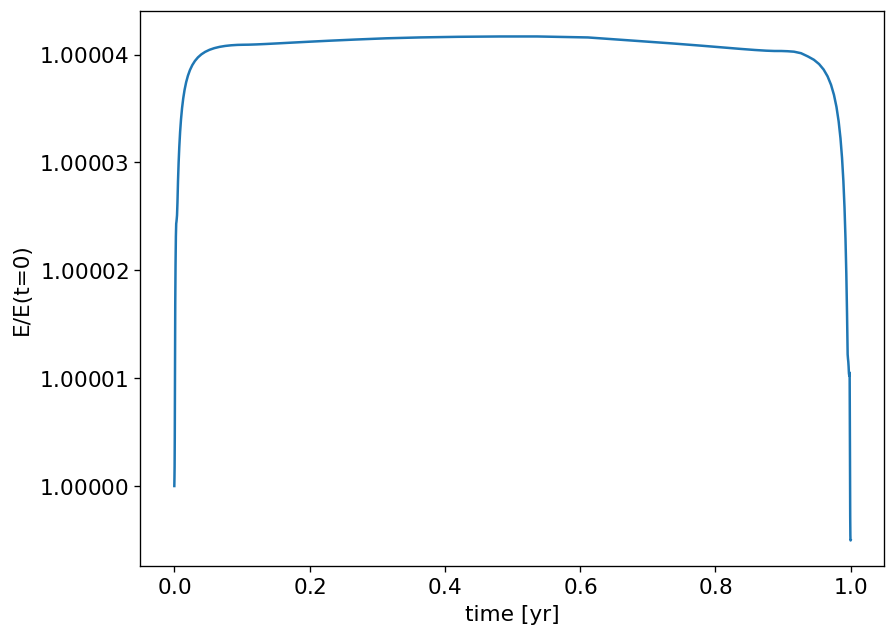

In [10]:
e = []
ts = o.time
for n in range(o.npts()):
    e.append(o.energy(n))
    
fig, ax = plt.subplots()
ax.plot(ts, e/e[0])
ax.set_xlabel("time [yr]")
ax.set_ylabel("E/E(t=0)")
ax.ticklabel_format(useOffset=False)

Now let's do 10 orbits

In [11]:
o = orbit.OrbitsRK4(1.0, 0.95)
o.integrate(0.05, 1.e-5, 20*o.kepler_period())

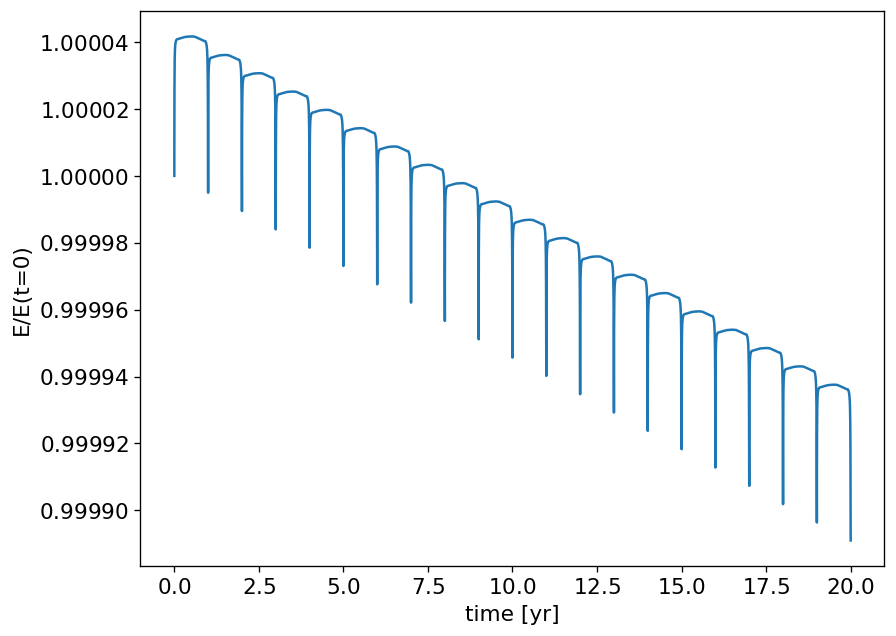

In [12]:
e = []
ts = o.time
for n in range(o.npts()):
    e.append(o.energy(n))
    
fig, ax = plt.subplots()
ax.plot(ts, e/e[0])
ax.set_xlabel("time [yr]")
ax.set_ylabel("E/E(t=0)")
ax.ticklabel_format(useOffset=False)

We can see that RK4 does not conserve energy!  There is a steady decrease in the total energy over 20 orbits.  If we wanted to evolve for millions of years, this would certainly be a problem.  Making the tolerance tighter certainly will help, but it will also make things a lot more expensive.

The problem is that 4th order Runge-Kutta does not know anything about energy conservation.